In [1]:
import time
import random
import torch
from datasets import load_dataset

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
import warnings
warnings.filterwarnings("ignore", ".*torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly.*")
warnings.filterwarnings("ignore", ".*None of the inputs have requires_grad=True. Gradients will be None.*")

In [4]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tyler-romero. Use `wandb login --relogin` to force relogin


True

In [5]:
ds = load_dataset("HuggingFaceM4/the_cauldron", "vqav2", split="train")  # https://huggingface.co/datasets/HuggingFaceM4/the_cauldron
len(ds)

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/27 [00:00<?, ?it/s]

82772

{'user': 'What is this photo taken looking through?\nConcise answer only.', 'assistant': 'Net.', 'source': 'VQAv2'}


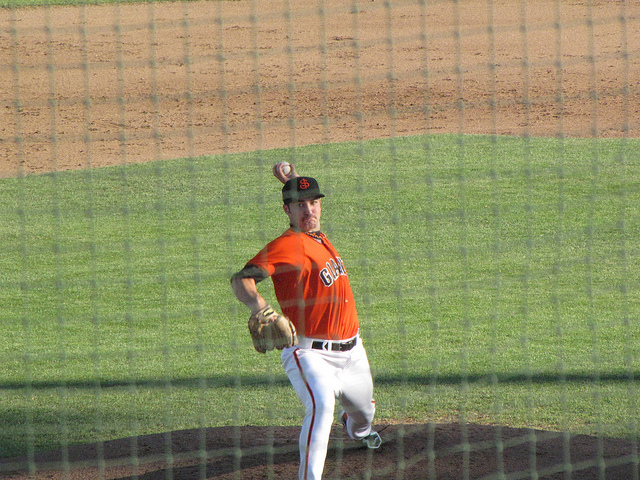

In [6]:
print(ds[0]["texts"][0])
ds[0]["images"][0]

In [7]:
from seahorse.models.seahorse import SeahorseModel
from seahorse.data.utils import random_pil

In [8]:
try:
    del model
    print("Model deleted")
except NameError:
    pass

start = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = (
    torch.bfloat16
    if torch.cuda.is_available() and torch.cuda.is_bf16_supported()
    else torch.float32
)
model = SeahorseModel().to(device, dtype)
print(f"Model loaded in {time.time() - start:.2f}s")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Image token ID: 32012
Model loaded in 3.88s


In [9]:
from peft.mapping import get_peft_model
from peft.tuners.lora import LoraConfig

def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    for name, module in model.named_modules():
        # Only lora the LLM
        if "language_model" not in name:
            continue
        if isinstance(module, cls):
            lora_module_names.add(name)
    if 'language_model.lm_head' in lora_module_names: # needed for 16-bit
        lora_module_names.remove('language_model.lm_head')
    lora_module_names = sorted(list(lora_module_names))
    print(lora_module_names)
    return lora_module_names

lora_config = LoraConfig(
    r=8,  # 128 caused divergence
    lora_alpha=8,
    target_modules=find_all_linear_names(model),
    modules_to_save=[
        "vision_projector",
        "language_model.lm_head",
        "language_model.model.embed_tokens",  # disabling this really hurt perf
    ],
    lora_dropout=0.05,
    bias="none",
    init_lora_weights="pissa_niter_15",
    use_dora=False,  # using dora led to no improvement but was 2x as slow
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Could not find the bitsandbytes CUDA binary at PosixPath('/home/tromero/miniforge3/envs/seahorse/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cuda121.so')
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


['language_model.model.layers.0.mlp.down_proj', 'language_model.model.layers.0.mlp.gate_up_proj', 'language_model.model.layers.0.self_attn.o_proj', 'language_model.model.layers.0.self_attn.qkv_proj', 'language_model.model.layers.1.mlp.down_proj', 'language_model.model.layers.1.mlp.gate_up_proj', 'language_model.model.layers.1.self_attn.o_proj', 'language_model.model.layers.1.self_attn.qkv_proj', 'language_model.model.layers.10.mlp.down_proj', 'language_model.model.layers.10.mlp.gate_up_proj', 'language_model.model.layers.10.self_attn.o_proj', 'language_model.model.layers.10.self_attn.qkv_proj', 'language_model.model.layers.11.mlp.down_proj', 'language_model.model.layers.11.mlp.gate_up_proj', 'language_model.model.layers.11.self_attn.o_proj', 'language_model.model.layers.11.self_attn.qkv_proj', 'language_model.model.layers.12.mlp.down_proj', 'language_model.model.layers.12.mlp.gate_up_proj', 'language_model.model.layers.12.self_attn.o_proj', 'language_model.model.layers.12.self_attn.qkv

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x7B22D8378750>, 'text': '<|user|>\n<image> What is this photo taken looking through?\nConcise answer only.\n<|assistant|>\nNet.'}


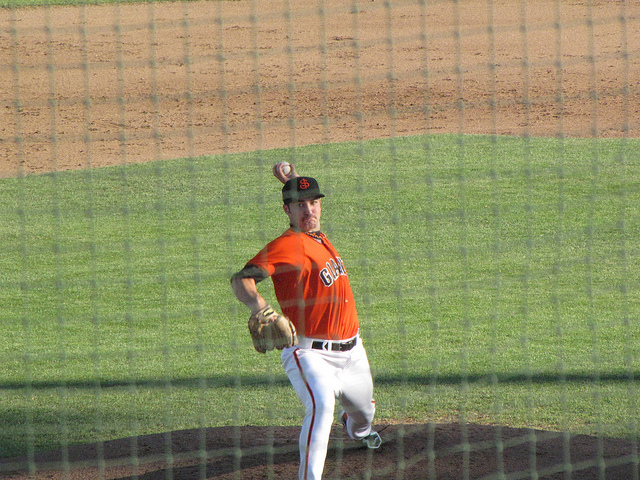

In [10]:
from torch.utils.data import Dataset

def make_instruction_text(text: dict, image) -> str:
    image_token = "<image> " if image is not None else ""
    return f"<|user|>\n{image_token}{text['user']}\n<|assistant|>\n{text['assistant']}"

class SeahorseDataset(Dataset):
    def __init__(self, dataset, ablate_images: bool | str = False):
        self.dataset = dataset
        self.ablate_images = ablate_images

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        if not item['images']:
            print(f"Skipping example {idx} as it does not contain any images")
            return None
        if len(item['images']) > 1:
            raise ValueError("Only one image per example is supported")

        text = item['texts'][0]  # TODO: Handle multiple texts
        if self.ablate_images == "random":
            image = random_pil()
        elif self.ablate_images == "no_img":
            image = None
        else:
            image = item['images'][0]

        output = {
            'image': image,
            'text': make_instruction_text(text, image=image)
        }
        return output


custom_ds = SeahorseDataset(ds, ablate_images=False)
print(custom_ds[0])
custom_ds[0]['image']

In [11]:
class SeahorseDataCollator:
    def __init__(self, model):
        self.model = model

    def __call__(self, features: dict) -> dict:
        batch = {}
        images = [f['image'] for f in features]
        if images[0] is None:
            if not all(img is None for img in images):
                raise ValueError("All images in batch should be None if one image is None")
        else:
            batch['pixel_values'] = model.preprocess_image(images)
        tokens = model.tokenize_text([f['text'] for f in features])
        batch['input_ids'] = tokens.input_ids
        batch['attention_mask'] = tokens.attention_mask

        # Set labels for language modeling
        batch['labels'] = batch['input_ids'].clone()
        return batch

# Try to run a single batch through the data collator
sample_batch = [custom_ds[i] for i in range(min(2, len(custom_ds)))]
collator = SeahorseDataCollator(model=model)
try:
    processed_batch = collator(sample_batch)
    print("Batch processed successfully")
    for k, v in processed_batch.items():
        print(f"{k}: {v.shape}")
except Exception as e:
    print(f"Error processing batch: {str(e)}")

# del sample_batch, processed_batch

Batch processed successfully
pixel_values: torch.Size([2, 3, 224, 224])
input_ids: torch.Size([2, 22])
attention_mask: torch.Size([2, 22])
labels: torch.Size([2, 22])


In [12]:
if False:
    image_patches = model.encode_and_project_image(processed_batch["pixel_values"].to(device, dtype))
    output_embeds, new_attention_mask, new_output_labels, = model.merge_text_and_image_tokens(
        text_token_ids=processed_batch["input_ids"].to(device),
        image_patch_embeds=image_patches,
        attention_mask=processed_batch["attention_mask"].to(device),
        text_labels=processed_batch["labels"].to(device)
    )

In [13]:
def generate_two_word_name():
    adjectives = [
        'happy', 'sunny', 'clever', 'brave', 'gentle', 'kind', 'swift', 'bright',
        'wise', 'calm', 'eager', 'fierce', 'jolly', 'lively', 'merry', 'proud',
        'quiet', 'witty', 'zealous', 'daring', 'elegant', 'friendly', 'graceful',
        'vibrant', 'serene', 'bold', 'charming', 'dazzling', 'enchanting', 'fantastic',
        'glorious', 'harmonious', 'innovative', 'joyful', 'keen', 'luminous', 'majestic',
        'noble', 'optimistic', 'peaceful', 'radiant', 'splendid', 'tranquil', 'upbeat',
        'vivacious', 'whimsical', 'exuberant', 'youthful', 'zestful', 'adventurous',
        'blissful', 'cosmic', 'dynamic', 'ethereal', 'flourishing', 'gallant'
    ]
    nouns = [
        'panda', 'river', 'mountain', 'forest', 'ocean', 'star', 'cloud', 'tiger',
        'falcon', 'meadow', 'canyon', 'island', 'breeze', 'phoenix', 'dolphin',
        'eagle', 'garden', 'horizon', 'lagoon', 'nebula', 'oasis', 'quasar',
        'aurora', 'blossom', 'cascade', 'dune', 'ember', 'fjord', 'galaxy',
        'harbor', 'iceberg', 'jungle', 'kaleidoscope', 'lighthouse', 'mirage',
        'nova', 'orchid', 'plateau', 'reef', 'savanna', 'tempest', 'universe',
        'volcano', 'waterfall', 'zenith', 'archipelago', 'beacon', 'citadel',
        'delta', 'eclipse', 'fountain', 'geyser', 'haven', 'isthmus'
    ]
    return f"{random.choice(adjectives)}-{random.choice(nouns)}"

In [14]:
import torch

def get_gpu_memory_usage():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / 1024**3  # Convert to GB
    else:
        return 0

torch.cuda.empty_cache()
gpu_memory = get_gpu_memory_usage()

print(f"GPU Memory Usage: {gpu_memory:.2f} GB")

GPU Memory Usage: 7.54 GB


In [15]:
from transformers.trainer import Trainer
from transformers.training_args import TrainingArguments

# Define training arguments
run_name = generate_two_word_name()
print(f"Run name: {run_name}")
training_args = TrainingArguments(
    # Dataset-related args
    label_names=["labels"],
    remove_unused_columns=False,
    # Training-related args
    num_train_epochs=1,
    per_device_train_batch_size=32,  # multiples of 8 are prefered
    gradient_checkpointing=True,  # if enabled, slows training by ~20%
    torch_compile=True,
    bf16=True,
    optim="adamw_torch_fused",
    learning_rate=1e-3,  # https://github.com/haotian-liu/LLaVA/blob/main/scripts/v1_5/pretrain.sh
    weight_decay=0.00,
    warmup_ratio=0.03,
    lr_scheduler_type="cosine",
    dataloader_num_workers=4,
    group_by_length=False,  # ?
    # Eval-related arguments
    evaluation_strategy="no",
    per_device_eval_batch_size=32,
    eval_accumulation_steps=1,
    # Tracking-related arguments
    run_name=run_name,
    output_dir=f"./results/{run_name}",
    report_to="wandb",
    logging_dir="./logs",
    logging_steps=10,
    include_num_input_tokens_seen=True,
    # include_tokens_per_second=True,
    # skip_memory_metrics=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=custom_ds,
    data_collator=SeahorseDataCollator(model=model),
)
trainer.train()

Run name: blissful-isthmus


/home/tromero/miniforge3/envs/seahorse/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
10,7.023000
20,4.016900
30,3.712600
40,3.494400
50,3.633400
60,3.683400
70,3.559900
80,3.620300
90,3.726600
100,3.775900


W0702 15:07:50.754000 135398400558912 torch/_dynamo/convert_frame.py:357] torch._dynamo hit config.cache_size_limit (8)
W0702 15:07:50.754000 135398400558912 torch/_dynamo/convert_frame.py:357]    function: 'torch_dynamo_resume_in_merge_text_and_image_tokens_at_190' (/home/tromero/workspace/seahorse/seahorse/models/seahorse.py:190)
W0702 15:07:50.754000 135398400558912 torch/_dynamo/convert_frame.py:357]    last reason: L['sl'] == 30                                                 # _dynamo/output_graph.py:422 in init_ambient_guards
W0702 15:07:50.754000 135398400558912 torch/_dynamo/convert_frame.py:357] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0702 15:07:50.754000 135398400558912 torch/_dynamo/convert_frame.py:357] To diagnose recompilation issues, see https://pytorch.org/docs/master/compile/troubleshooting.html.
